***Topic 2: Evaluation & Comparison***

In [38]:
#Imports (Evaluation)
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

***Imported essential libraries for evaluation, modeling, and matrix operations in this step.***

In [6]:
cd /Users/dpmalaviya/Library/CloudStorage/OneDrive-DePaulUniversity/Quarters/3rd quarter/DSC 478/Project/data

/Users/dpmalaviya/Library/CloudStorage/OneDrive-DePaulUniversity/Quarters/3rd quarter/DSC 478/Project/data


In [10]:
df = pd.read_csv("video_game_reviews.csv")

***Loaded the whole video game review dataset into a DataFrame for processing and modeling and getting outputs and results.***

In [12]:
print("Dataset shape:", df.shape)
print("Rating summary:\n", df['User Rating'].describe())
print("Missing values:\n", df.isna().sum().sort_values(ascending=False))

Dataset shape: (47774, 18)
Rating summary:
 count    47774.000000
mean        29.719329
std          7.550131
min         10.100000
25%         24.300000
50%         29.700000
75%         35.100000
max         49.500000
Name: User Rating, dtype: float64
Missing values:
 Game Title                 0
User Rating                0
Game Mode                  0
User Review Text           0
Story Quality              0
Soundtrack Quality         0
Graphics Quality           0
Game Length (Hours)        0
Multiplayer                0
Genre                      0
Release Year               0
Publisher                  0
Developer                  0
Requires Special Device    0
Platform                   0
Price                      0
Age Group Targeted         0
Min Number of Players      0
dtype: int64


***Confirmed here that the dataset is fully cleaned and contains no missing values.***
***Also displayed the dataset size and a statistical summary of the 'User Rating' column for better clarity.***

In [14]:
#Create user-item matrix for rating prediction
user_item_matrix = df.pivot_table(index='User Review Text', columns='Game Title', values='User Rating')
ratings_matrix = user_item_matrix.fillna(0)
print("User-item matrix shape:", ratings_matrix.shape)

User-item matrix shape: (12, 40)


***Created a pivot table where rows represent pseudo-users (review texts) and columns represent games. Values are user ratings.
This matrix here forms the basis for collaborative filtering models.***

In [16]:
#RMSE function
def compute_rmse(true_ratings, pred_ratings):
    mask = true_ratings > 0
    mse = mean_squared_error(true_ratings[mask], pred_ratings[mask])
    return np.sqrt(mse)

***Defined a function to calculate RMSE only for known ratings, and ignoring the artificially filled zeros (which indicate missing data).***

In [18]:
#SVD Implementation (Matrix Factorization)
k_svd = min(ratings_matrix.shape) - 1
U, sigma, Vt = svds(ratings_matrix.values, k=k_svd)
sigma = np.diag(sigma)
pred_ratings_svd = np.dot(np.dot(U, sigma), Vt)
rmse_svd = compute_rmse(ratings_matrix.values, pred_ratings_svd)
print(f"\nRMSE (SVD on full matrix): {rmse_svd:.4f}")



RMSE (SVD on full matrix): 0.1092


***Applied matrix factorization (SVD) to uncover latent relationships between users and games. This is a standard collaborative filtering approach. RMSE here gives us a measure of prediction error which will be easy for uus to work ahead.***

In [20]:
#User-based KNN (Collaborative Filtering)
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(ratings_matrix)
pred_ratings_knn = ratings_matrix.copy()
for idx in range(len(ratings_matrix)):
    distances, indices = model_knn.kneighbors(ratings_matrix.iloc[idx:idx+1], n_neighbors=5)
    mean_rating = ratings_matrix.iloc[indices[0]].mean(axis=0)
    pred_ratings_knn.iloc[idx] = mean_rating

rmse_knn = compute_rmse(ratings_matrix.values, pred_ratings_knn.values)
print(f"RMSE (User-KNN on full matrix): {rmse_knn:.4f}")

RMSE (User-KNN on full matrix): 0.5661


***Built a collaborative filtering model here using cosine similarity between users which predicted ratings by averaging those from the 5 most similar users. RMSE here is calculated to compare with SVD results.***


In [22]:
#Filtering to reduce sparsity (only games with >100 ratings)
rating_counts = df['Game Title'].value_counts()
popular_games = rating_counts[rating_counts > 100].index
filtered_df = df[df['Game Title'].isin(popular_games)]
filtered_matrix = filtered_df.pivot_table(index='User Review Text', columns='Game Title', values='User Rating').fillna(0)

k_svd_filtered = min(filtered_matrix.shape) - 1
U_f, sigma_f, Vt_f = svds(filtered_matrix.values, k=k_svd_filtered)
sigma_f = np.diag(sigma_f)
pred_filtered_svd = np.dot(np.dot(U_f, sigma_f), Vt_f)
rmse_filtered_svd = compute_rmse(filtered_matrix.values, pred_filtered_svd)
print(f"RMSE (SVD on filtered matrix): {rmse_filtered_svd:.4f}")

RMSE (SVD on filtered matrix): 0.1092


***Sparsing the data can hurt model performance. Here, we keep only games with over 100 ratings to ensure sufficient data. Re-ran SVD and compared RMSE to observe how sparsity reduction impacts accuracy.***

***Methodology & Parameter Adjustments***

In [24]:
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

In [26]:
mode_genre = df['Genre'].mode()[0]
df['Genre'] = df['Genre'].replace("Unknown", mode_genre)

***Standardized the 'Genre' field by replacing 'Unknown' with the most frequent genre.This avoids skew in genre-based modeling or filtering.***

In [28]:
vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = vectorizer.fit_transform(df['User Review Text'])

***Converted the user review text into numerical vectors using TF-IDF (text importance). Then, applied PCA to reduce dimensionality while preserving 95% of the data variance. This prepares the review data for content-based or hybrid recommendation modeling.***

In [30]:
# Show first few rows of TF-IDF matrix
print("Sample TF-IDF vector for first review:")
print(tfidf_matrix[0].toarray())

# Get and print top TF-IDF terms overall
feature_names = vectorizer.get_feature_names_out()
tfidf_sum = tfidf_matrix.sum(axis=0).A1
top_indices = np.argsort(tfidf_sum)[-10:][::-1]

print("\nTop 10 keywords across all reviews:")
for i in top_indices:
    print(f"{feature_names[i]}: {tfidf_sum[i]:.2f}")

Sample TF-IDF vector for first review:
[[0.         0.         0.         0.45907995 0.21866242 0.
  0.         0.21866242 0.         0.         0.         0.
  0.45907995 0.52164191 0.         0.45907995]]

Top 10 keywords across all reviews:
amazing: 10032.93
game: 10032.90
but: 10032.90
the: 9116.48
too: 7441.19
many: 7441.19
bugs: 7441.19
is: 7111.09
gameplay: 7111.09
graphics: 6503.47


In [32]:
print("TF-IDF matrix shape:", tfidf_matrix.shape)

TF-IDF matrix shape: (47774, 16)


In [34]:
pca = PCA(n_components=0.95)  # retain 95% variance
tfidf_pca = pca.fit_transform(tfidf_matrix.toarray())
print("PCA-reduced shape:", tfidf_pca.shape)

PCA-reduced shape: (47774, 5)


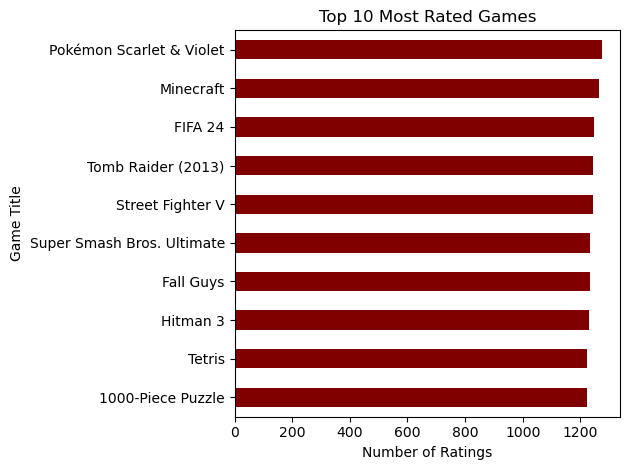

In [40]:
df['Game Title'].value_counts().head(10).plot(kind='barh', color='maroon')
plt.title("Top 10 Most Rated Games")
plt.gca().invert_yaxis()
plt.xlabel("Number of Ratings")
plt.tight_layout()
plt.show()

In [44]:
cd /Users/dpmalaviya/Library/CloudStorage/OneDrive-DePaulUniversity/Quarters/3rd quarter/DSC 478/Project/work/om

/Users/dpmalaviya/Library/CloudStorage/OneDrive-DePaulUniversity/Quarters/3rd quarter/DSC 478/Project/work/om


In [52]:
np.save("tfidf_pca.npy", tfidf_pca)